In [1]:
!pip install networkx matplotlib tabulate numpy

  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached contourpy-1.1.1-cp38-cp38-win_amd64.whl (477 kB)


You should consider upgrading via the 'C:\Users\karlp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


Running large-scale graph coloring benchmarks...

Processing Large Random (1000 vertices, 10% dense)...

Processing Dense (500 vertices, 50% dense)...

Processing Very Large Sparse (2000 vertices, ~1% dense)...

Processing Large Grid (50x50 = 2500 vertices)...

Processing Social Network-like (1000 vertices)...

Detailed Performance Results:
+----------------------------------------------+--------------+----------+-------------+------------------+--------------------+
| Graph Type                                   | Algorithm    | Colors   | Time (ms)   | Relative Speed   | Color Efficiency   |
+==============================================+==============+==========+=============+==================+====================+
| Large Random (1000 vertices, 10% dense)      | Greedy       | 31       | 5.46        | 1.00x            | 1.19x              |
+----------------------------------------------+--------------+----------+-------------+------------------+--------------------+
| Large Rand

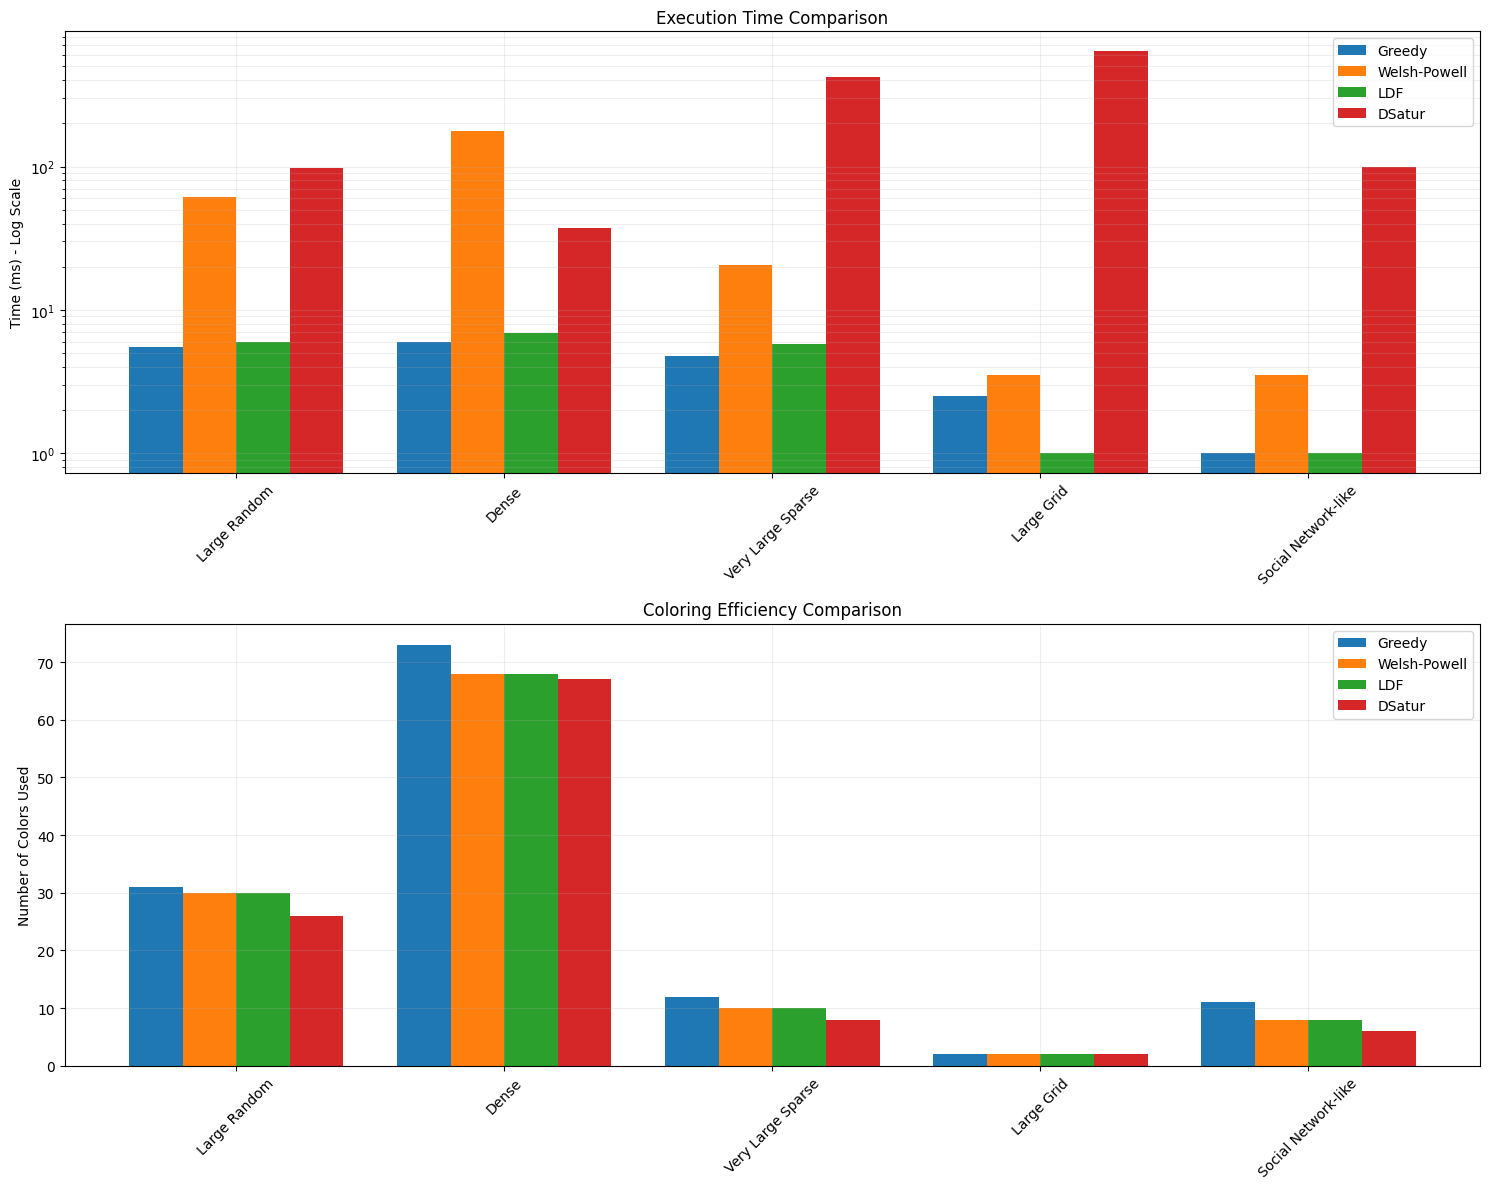


All tests passed.


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from matplotlib.colors import CSS4_COLORS
import time
import random
from operator import itemgetter
import numpy as np
from tabulate import tabulate

class NodeInfo:
    def __init__(self, sat, deg, vertex):
        self.sat = sat
        self.deg = deg
        self.vertex = vertex

class MaxSat:
    def __call__(self, node):
        return (-node.sat, -node.deg, node.vertex)

class Graph:
    def __init__(self, numNodes):
        if numNodes <= 0:
            raise ValueError("Number of nodes must be positive")
        self.n = numNodes
        self.adj = [[] for _ in range(numNodes)]
        self.G = nx.Graph()
        self.G.add_nodes_from(range(numNodes))
        
    def addEdge(self, u, v):
        # Avoid self-loops
        if u == v:
            return
        # Validate vertices
        if u < 0 or u >= self.n or v < 0 or v >= self.n:
            raise IndexError("Vertex index out of bounds")
        # Avoid duplicate edges
        if v not in self.adj[u]:
            self.adj[u].append(v)
            self.adj[v].append(u)
            self.G.add_edge(u, v)

class ColoringAlgorithms:
    def __init__(self, graph):
        self.graph = graph
        self.n = len(graph.adj)
        self.color_list = list(CSS4_COLORS.keys())[:10]
        
    def welsh_powell_coloring(self):
        """Welsh-Powell algorithm - efficient for sparse graphs."""
        
        # Calculate degrees and sort vertices by degree in descending order
        degrees = [(v, len(self.graph.adj[v])) for v in range(self.n)]
        sorted_vertices = [v for v, d in sorted(degrees, key=itemgetter(1), reverse=True)]
        
        c = [-1] * self.n
        current_color = 0
        
        start_time = time.time()  # Start timing after initializations
        
        while -1 in c:
            # Find uncolored vertices
            uncolored = [v for v in sorted_vertices if c[v] == -1]
            if not uncolored:
                break
                
            # Color uncolored vertices if possible with current_color
            for v in uncolored:
                used = set(c[adj] for adj in self.graph.adj[v] if c[adj] != -1)
                if current_color not in used:
                    c[v] = current_color
            current_color += 1
        
        execution_time = time.time() - start_time
        return c, execution_time, len(set(c))

    def ldf_coloring(self):
        """Largest-Degree-First coloring algorithm."""
        
        # Sort vertices by degree in descending order
        degrees = [(v, len(self.graph.adj[v])) for v in range(self.n)]
        vertex_order = [v for v, d in sorted(degrees, key=itemgetter(1), reverse=True)]
        
        c = [-1] * self.n
        
        start_time = time.time()  # Start timing after initializations
        
        for v in vertex_order:
            used = set(c[adj] for adj in self.graph.adj[v] if c[adj] != -1)
            
            # Find first available color
            color = 0
            while color in used:
                color += 1
            
            c[v] = color
        
        execution_time = time.time() - start_time
        return c, execution_time, len(set(c))

    def greedy_coloring(self):
        """Simple greedy coloring algorithm."""
        c = [-1] * self.n
        
        start_time = time.time()  # Start timing after initializations
        
        for u in range(self.n):
            used = set(c[v] for v in self.graph.adj[u] if c[v] != -1)
            
            color = 0
            while color in used:
                color += 1
            c[u] = color
        
        execution_time = time.time() - start_time
        return c, execution_time, len(set(c))
    
    def dsatur_coloring(self):
        """DSatur coloring algorithm."""
        
        c = [-1] * self.n
        saturation = [0] * self.n  # Number of different colors in adjacent vertices
        colored_neighbors = [set() for _ in range(self.n)]  # Colors of adjacent vertices
        
        degrees = [len(self.graph.adj[v]) for v in range(self.n)]
        first_vertex = max(range(self.n), key=lambda v: degrees[v])  # Vertex with maximum degree
        c[first_vertex] = 0  # Assign first color to first_vertex
        
        # Update saturation and colored_neighbors for adjacent vertices
        for v in self.graph.adj[first_vertex]:
            if c[v] == -1:
                colored_neighbors[v].add(0)
                saturation[v] = len(colored_neighbors[v])
        
        start_time = time.time()  # Start timing after initializations
        
        colored_count = 1
        while colored_count < self.n:
            # Select uncolored vertex with highest saturation
            uncolored_vertices = [v for v in range(self.n) if c[v] == -1]
            next_vertex = max(uncolored_vertices, key=lambda v: (saturation[v], degrees[v]))
            
            # Find the smallest color not used by adjacent vertices
            used_colors = colored_neighbors[next_vertex]
            color = 0
            while color in used_colors:
                color += 1
            
            c[next_vertex] = color  # Assign color to vertex
            colored_count += 1
            
            # Update saturation and colored_neighbors for adjacent vertices
            for v in self.graph.adj[next_vertex]:
                if c[v] == -1:
                    if color not in colored_neighbors[v]:
                        colored_neighbors[v].add(color)
                        saturation[v] = len(colored_neighbors[v])
        
        execution_time = time.time() - start_time
        return c, execution_time, len(set(c))

    def benchmark(self, runs=3):
        """Run multiple times to get stable measurements."""
        algorithms = [
            (self.greedy_coloring, "Greedy"),
            (self.welsh_powell_coloring, "Welsh-Powell"),
            (self.ldf_coloring, "LDF"),
            (self.dsatur_coloring, "DSatur")
        ]
        
        results = []
        for algo, name in algorithms:
            times = []
            colors = []
            for _ in range(runs):
                coloring, time_taken, colors_used = algo()
                times.append(time_taken * 1000)  # Convert to ms
                colors.append(colors_used)
            
            # Take median values
            median_time = np.median(times)
            median_colors = int(np.median(colors))
            results.append((name, median_colors, median_time))
            
        return results

def generate_test_graphs():
    """Generate various types of large test graphs."""
    test_cases = []
    
    # Very Large Random Graph (1000 vertices, ~10% density)
    num_nodes = 1000
    p = 0.1  # Probability for edge creation
    nx_graph1 = nx.gnp_random_graph(num_nodes, p)
    G1 = Graph(num_nodes)
    for u, v in nx_graph1.edges():
        G1.addEdge(u, v)
    test_cases.append(("Large Random (1000 vertices, 10% dense)", G1))
    
    # Dense Graph (500 vertices, ~50% density)
    num_nodes = 500
    p = 0.5
    nx_graph2 = nx.gnp_random_graph(num_nodes, p)
    G2 = Graph(num_nodes)
    for u, v in nx_graph2.edges():
        G2.addEdge(u, v)
    test_cases.append(("Dense (500 vertices, 50% dense)", G2))
    
    # Large Sparse Graph (2000 vertices, ~1% density)
    num_nodes = 2000
    p = 0.01
    nx_graph3 = nx.gnp_random_graph(num_nodes, p)
    G3 = Graph(num_nodes)
    for u, v in nx_graph3.edges():
        G3.addEdge(u, v)
    test_cases.append(("Very Large Sparse (2000 vertices, ~1% dense)", G3))
    
    # Large Grid (50x50 = 2500 vertices)
    num_nodes = 2500
    G4 = Graph(num_nodes)
    for i in range(50):
        for j in range(50):
            v = i * 50 + j
            if j < 49:  # Horizontal connections
                G4.addEdge(v, v + 1)
            if i < 49:  # Vertical connections
                G4.addEdge(v, v + 50)
    test_cases.append(("Large Grid (50x50 = 2500 vertices)", G4))
    
    # Social Network-like Graph (1000 vertices with hubs)
    num_nodes = 1000
    G5 = Graph(num_nodes)
    # Create some hub vertices
    hubs = random.sample(range(num_nodes), 20)
    for hub in hubs:
        connections = random.sample(range(num_nodes), 100)
        for v in connections:
            if v != hub:
                G5.addEdge(hub, v)
    # Add some random edges
    for i in range(num_nodes):
        connections = random.sample(range(num_nodes), 5)
        for j in connections:
            if j != i:
                G5.addEdge(i, j)
    test_cases.append(("Social Network-like (1000 vertices)", G5))
    
    return test_cases

def print_performance_table(all_results):
    """Print a formatted table of all results."""
    headers = ["Graph Type", "Algorithm", "Colors", "Time (ms)", "Relative Speed", "Color Efficiency"]
    rows = []
    
    for graph_type, results in all_results:
        # Calculate relative metrics
        min_time = min(result[2] for result in results)
        min_colors = min(result[1] for result in results)
        
        for algo_name, colors, time_ms in results:
            relative_speed = f"{time_ms/min_time:.2f}x"
            color_efficiency = f"{colors/min_colors:.2f}x"
            rows.append([
                graph_type,
                algo_name,
                colors,
                f"{time_ms:.2f}",
                relative_speed,
                color_efficiency
            ])
        rows.append([""] * 6)  # Empty row for separation
    
    print(tabulate(rows, headers=headers, tablefmt="grid"))

def create_performance_plot(all_results):
    """Create bar plots comparing algorithm performance."""
    n_graphs = len(all_results)
    algorithms = ["Greedy", "Welsh-Powell", "LDF", "DSatur"]
    n_algorithms = len(algorithms)
    
    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Prepare data
    graph_types = []
    times = {algo: [] for algo in algorithms}
    colors = {algo: [] for algo in algorithms}
    
    for graph_type, results in all_results:
        graph_types.append(graph_type.split('(')[0].strip())
        for algo_name, n_colors, time_ms in results:
            times[algo_name].append(time_ms)
            colors[algo_name].append(n_colors)
    
    # Plot execution times (log scale)
    width = 0.2
    positions = np.arange(n_graphs)
    for i, algo in enumerate(algorithms):
        offset = (i - (n_algorithms - 1)/2) * width
        ax1.bar(positions + offset, times[algo], width, label=algo)
    
    ax1.set_yscale('log')
    ax1.set_ylabel('Time (ms) - Log Scale')
    ax1.set_title('Execution Time Comparison')
    ax1.set_xticks(positions)
    ax1.set_xticklabels(graph_types, rotation=45)
    ax1.legend()
    ax1.grid(True, which="both", ls="-", alpha=0.2)
    
    # Plot number of colors used
    for i, algo in enumerate(algorithms):
        offset = (i - (n_algorithms - 1)/2) * width
        ax2.bar(positions + offset, colors[algo], width, label=algo)
    
    ax2.set_ylabel('Number of Colors Used')
    ax2.set_title('Coloring Efficiency Comparison')
    ax2.set_xticks(positions)
    ax2.set_xticklabels(graph_types, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.2)
    
    plt.tight_layout()
    return fig

def test_coloring_algorithms():
    """Simple unit tests for coloring algorithms."""
    # Test graph with known chromatic number
    G = Graph(5)
    G.addEdge(0, 1)
    G.addEdge(1, 2)
    G.addEdge(2, 3)
    G.addEdge(3, 4)
    G.addEdge(4, 0)  # Creates a cycle of length 5
    algorithms = ColoringAlgorithms(G)
    
    for method in [algorithms.greedy_coloring, algorithms.welsh_powell_coloring,
                   algorithms.ldf_coloring, algorithms.dsatur_coloring]:
        coloring, _, colors_used = method()
        assert colors_used >= 3, f"Algorithm {method.__name__} failed on test graph"

if __name__ == '__main__':
    print("Running large-scale graph coloring benchmarks...")
    
    all_results = []
    test_cases = generate_test_graphs()
    
    for graph_type, G in test_cases:
        print(f"\nProcessing {graph_type}...")
        algorithms = ColoringAlgorithms(G)
        results = algorithms.benchmark(runs=3)
        all_results.append((graph_type, results))
    
    # Print detailed performance table
    print("\nDetailed Performance Results:")
    print_performance_table(all_results)
    
    # Create and show performance plots
    fig = create_performance_plot(all_results)
    plt.show()
    
    # Run simple unit tests
    test_coloring_algorithms()
    print("\nAll tests passed.")
